In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom

import pandas as pd

In [ ]:
from nbdev.showdoc import *

# Tutorial - Classification of thoracic X-rays

> In this tutorial we will build a classifier that distinguishes between thoracic X-rays with pneumothorax and without pneumothorax. The image data is loaded directly from the DICOM source files, so no prior DICOM data handling is needed.

## Import X-rays

### Loading the data with `Datasets`

To analyze our dataset, we load the paths to the DICOM files with `get_dicom_files`. Then we can load the DICOM file with `dcmread` and plot it with `show`.

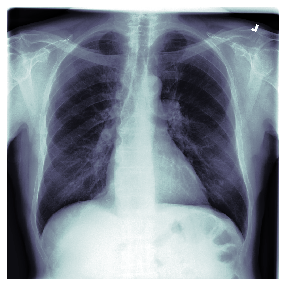

In [ ]:
#pneumothorax_source = Path("/home/moritz/Documents/siim/")

# TODO: create small dataset and use the following structure:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

items = get_dicom_files(pneumothorax_source/f"train/")
trn,val = RandomSplitter()(items)

items[3].dcmread().show()

In [ ]:
pneumothorax_source

Path('/home/moritz/.fastai/data/siim_small')

TODO: UPDATE TEXT: Then we detail the type transforms (applied to the items to form a tuple) and the dataset transforms. For our inputs we use `PILImage.create` and for our targets, the `parent_label` function to convert a filename to its class, followed by `Categorize`. We'll also map the wordnet category ids used in Imagenette to words.

The dataset transforms contain data augmentation using PIL and a resize to 128.

Next, we need to load the labels for the dataset. In this case, the labels indicate whether the xray shows a pneumothorax or not.

In [ ]:
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df.head()

,Unnamed: 0,file,label
0,0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,1,train/Pneumothorax/000001.dcm,Pneumothorax
2,2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,3,train/Pneumothorax/000003.dcm,Pneumothorax
4,4,train/Pneumothorax/000004.dcm,Pneumothorax


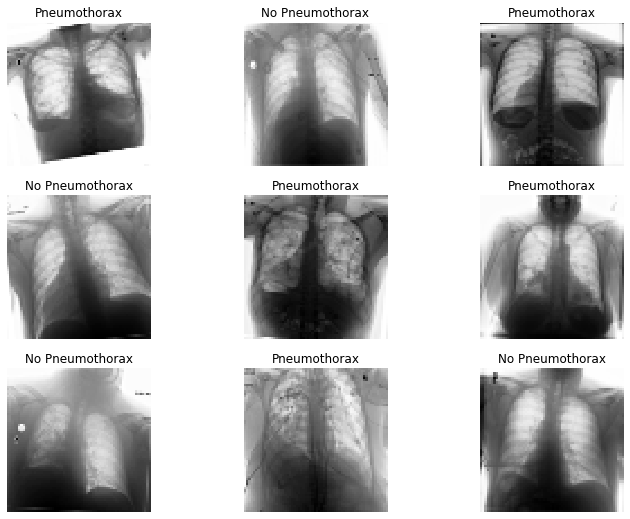

In [ ]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_x=lambda x:x[2],
                   splitter=RandomSplitter(),
                   get_y=lambda x:x[1],
                   batch_tfms=aug_transforms(size=64, flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=9, figsize=(12,9))

We can then pass all of this information to `Datasets`.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.818609,0.599153,0.727799,00:31


In [ ]:
learn.predict("/home/moritz/Documents/siim/dicom-images-test/_/thorax-xrays/ID_0011fe81e.dcm")

('No Pneumothorax', tensor(0), tensor([0.9471, 0.0529]))

In [ ]:
learn.tta(use_max=True)

(tensor([[0.9537, 0.1306],
         [0.9163, 0.6728],
         [0.6707, 0.8704],
         ...,
         [0.5828, 0.9105],
         [0.8390, 0.4654],
         [0.8505, 0.6969]]), TensorCategory([0, 1, 1,  ..., 0, 0, 0]))

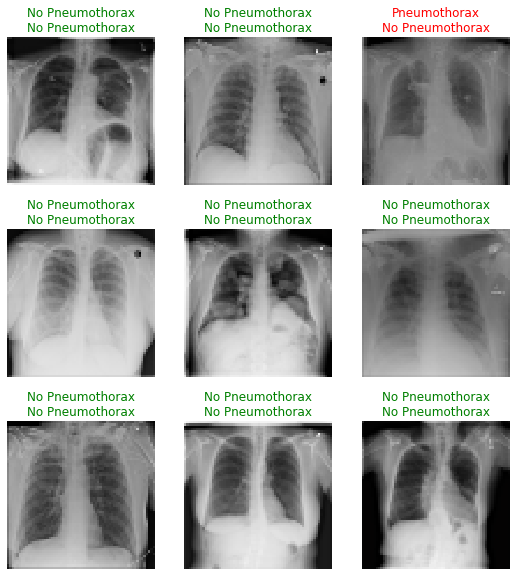

In [ ]:
learn.show_results(max_n=9)

In [ ]:
interp = Interpretation.from_learner(learn)

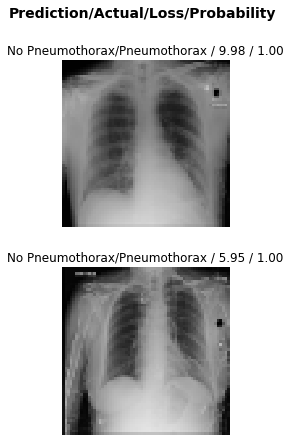

In [ ]:
interp.plot_top_losses(2)